In [1]:
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop
from timm.models.efficientvit_mit import GELUTanh, EfficientVitBlock, ResidualBlock, build_local_block
from pytorch_wavelets import DWTForward, DWTInverse
from tft.transforms import WPT2D, IWPT2D
from tft.utils import CompandGN, InvCompandGN
dataset = datasets.load_dataset("danjacobellis/LSDIR")

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [2]:
class TrainablePerChannelQuantize(nn.Module):
    """
    A replacement for 'tft.utils.Quantize' that:
      - Learns a per-channel scaling factor S[c].
      - Ensures each S[c] >= 1.
      - Ensures sum(S[c]) = (1 + excess_noise) * num_channels.
      - Multiplies each channel by ( base_scale * S[c] ), then adds noise or rounds.
    """
    def __init__(
        self,
        num_channels: int,
        bits: int = 8,
        excess_noise: float = 1.0,
        eps: float = 1e-3,
        channel_dim: int = 1
    ):
        """
        Args:
            num_channels: # of channels to learn separate scaling for (latent_dim in your case).
            bits: number of bits (8 => ~ ±127).
            excess_noise: If set to 1.0, sum of S[c] will be 2 * num_channels.
                          If set to 0, sum(S[c]) = 1 * num_channels (all scales fixed at 1).
            eps: small offset for the maximum scale => base_scale = (2**bits/2 - 1 - eps).
            channel_dim: dimension where channels reside (e.g. 1 for [B,C,H,W]).
        """
        super().__init__()
        self.num_channels = num_channels
        self.bits = bits
        self.eps = eps
        # "base_scale" is the global max scale for an 8-bit range (~127).
        self.base_scale = 2 ** (bits - 1) - 1 - eps  # e.g. ~127 for bits=8
        self.excess_noise = excess_noise
        self.channel_dim = channel_dim

        # We will re-parameterize each channel scale as S[c] = 1 + S'[c].
        # sum(S'[c]) = (excess_noise) * num_channels
        # So sum(S[c]) = (1+excess_noise)*num_channels.
        self.alpha = nn.Parameter(torch.zeros(num_channels))

    def _get_scales(self):
        """
        Returns a 1D tensor S of shape (num_channels,) with S[c] >= 1 and sum(S[c]) = ...
        """
        exp_alpha = self.alpha.exp()  # ensures positivity
        alpha_sum = exp_alpha.sum()

        # total "excess" across channels
        total_excess = self.excess_noise * self.num_channels

        # Distribute total_excess among channels proportionally
        S_prime = total_excess * exp_alpha / (alpha_sum + 1e-12)  # avoid /0

        # S[c] = 1 + S'[c]
        S = 1.0 + S_prime
        return S

    @property
    def scale(self):
        """
        Return a shape‐broadcastable scale for each channel: (1, num_channels, 1, 1) in 4D.
        This mimics self.scale from the old code, but now it's per-channel.
        """
        S = self._get_scales()  # shape [num_channels]
        shape_broadcast = [1] * 4  # If you want it for [B, C, H, W]
        shape_broadcast[self.channel_dim] = self.num_channels
        return (self.base_scale * S).view(*shape_broadcast)

    def forward(self, x: torch.Tensor):
        """
        x is expected to have 'num_channels' along dimension = self.channel_dim.
        We'll scale x per channel, add uniform noise (or round), and un‐scale.
        """
        s = self.scale  # shape [1, C, 1, 1] in 4D
        # Multiply
        x_scaled = x * s

        if self.training:
            # Add uniform noise in [-0.5, +0.5]
            x_scaled += (torch.rand_like(x_scaled) - 0.5)
        else:
            # Round
            x_scaled = torch.round(x_scaled)

        # Unscale
        x_quant = x_scaled / s
        return x_quant


In [3]:
def _divisors(n):
    divs = []
    i = 1
    while i * i <= n:
        if n % i == 0:
            divs.append(i)
            if i != n // i:
                divs.append(n // i)
        i += 1
    return sorted(divs)

class FactorizedConv2d(nn.Module):
    def __init__(self, in_chs, out_chs, bias=False):
        super().__init__()
        self.in_chs, self.out_chs = in_chs, out_chs
        g1, g2 = self._pick_groups(in_chs, out_chs)
        self.g1, self.g2 = g1, g2
        self.conv1 = nn.Conv2d(in_chs, in_chs, 1, groups=g1, bias=bias)
        self.conv2 = nn.Conv2d(in_chs, out_chs, 1, groups=g2, bias=bias)

    def _pick_groups(self, in_chs, out_chs):
        divs = _divisors(in_chs)
        best_g1, best_g2, best_cost = 1, in_chs, float('inf')
        for d in divs:
            g1, g2 = d, in_chs // d
            cost = (in_chs * in_chs / g1) + (in_chs * out_chs / g2)
            if cost < best_cost:
                best_cost, best_g1, best_g2 = cost, g1, g2
        return best_g1, best_g2

    def forward(self, x):
        x = self.conv1(x)
        x = einops.rearrange(x, 'b (g1 g2) h w -> b (g2 g1) h w', g1=self.g1, g2=self.g2)
        x = self.conv2(x)
        return x

class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)

class EfficientVitStageNoDS(nn.Module):
    def __init__(self, in_chs, out_chs, depth, norm_layer, act_layer):
        super(EfficientVitStageNoDS, self).__init__()
        blocks = [
            ResidualBlock(
                build_local_block(
                    in_channels=in_chs,
                    out_channels=out_chs,
                    stride=1,
                    expand_ratio=4,
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                    fewer_norm=True,
                    block_type='default'
                ),
                None,
            )
        ]
        in_chs = out_chs
        for _ in range(depth):
            blocks.append(
                EfficientVitBlock(
                    in_channels=in_chs,
                    head_dim=32,
                    expand_ratio=4,
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                )
            )
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)
        
def entropy_code(ints):
    webp_bytes = []
    for sample in ints:
        c_groups = sample.shape[0] // 3
        sample_webp = []
        for g in range(c_groups):
            group = sample[g*3 : g*3+3]
            group = (group + 127).clamp_(0, 255).byte()
            img = ToPILImage()(group)
            buff = io.BytesIO()
            img.save(buff, format='WEBP', lossless=True)
            sample_webp.append(buff.getbuffer())
        webp_bytes.append(sample_webp)
    
    return webp_bytes

def entropy_decode(webp_bytes):
    batch_out = []
    for sample_buffers in webp_bytes:
        group_tensors = []
        for buff in sample_buffers:
            with io.BytesIO(buff) as memfile:
                img = PIL.Image.open(memfile).convert('RGB')
            t = PILToTensor()(img).to(torch.int16) - 127
            group_tensors.append(t)
        sample_tensor = torch.cat(group_tensors, dim=0)
        sample_tensor = sample_tensor.unsqueeze(0)
        batch_out.append(sample_tensor)
    decoded = torch.cat(batch_out, dim=0)
    return decoded

In [4]:
class AutoEncoder2D(nn.Module):
    def __init__(self, channels, J, latent_dim, latent_bits):
        super().__init__()
        self.J=J
        self.latent_dim=latent_dim
        self.latent_bits=latent_bits
        self.wt = DWTForward(J=1, mode='periodization', wave='bior4.4')
        self.wpt = WPT2D(wt=self.wt, J=J)
        self.conv_down = FactorizedConv2d(channels*(4**J), latent_dim, bias=False)
        self.compandGN = CompandGN(
            num_features=self.latent_dim,
            num_groups=self.latent_dim,
            compand_eps=0.1,
            compand_pow=0.4,
            rescale=5
        )
        self.latent_quantize = TrainablePerChannelQuantize(
            num_channels=latent_dim,
            bits=latent_bits,
            excess_noise=3.0,
            eps=1e-3
        )
        self.latent_clamp = torch.nn.Hardtanh(min_val=-1.0,max_val=1.0)
        self.decompand = InvCompandGN(self.compandGN)
        self.conv_up = nn.Conv2d(latent_dim, channels*(4**J), kernel_size=1, padding=0, bias=False)
        self.vit =  EfficientVitStageNoDS(
            in_chs = channels*(4**J),
            out_chs = channels*(4**J),
            depth = 6,
            norm_layer=GroupNorm8,
            act_layer=GELUTanh,
        )
        self.iwt =  DWTInverse(mode='periodization', wave='bior4.4')
        self.iwpt = IWPT2D(iwt=self.iwt,J=J)
        self.reconstruct_clamp = torch.nn.Hardtanh(min_val=-1.0,max_val=1.0)

    def encode(self, x):
        x = self.wpt(x)
        x = self.conv_down(x)
        x = self.compandGN(x)
        x = self.latent_quantize(x)
        x = self.latent_clamp(x)
        x = self.latent_quantize.scale*x
        return x

    def decode(self, x):
        x = x/self.latent_quantize.scale
        x = self.decompand(x)
        x = self.conv_up(x)
        x = self.vit(x)
        x = self.iwpt(x)
        x = self.reconstruct_clamp(x)
        return x
        
    def forward(self, x):
        x = self.decode(self.encode(x))
        return x

In [5]:
config = SimpleNamespace()
config.F = 16
config.latent_dim = 108
config.latent_bits = 8
config.channels = 3
config.max_lr = 5e-3
config.min_lr = config.max_lr / 1e3
config.lr_pow = 2
config.img_size = 224
config.batch_size = 64
config.num_workers = 32
config.epochs = 3
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)

In [6]:
model = AutoEncoder2D(
    channels=config.channels,
    J = int(config.F**0.5),
    latent_dim=config.latent_dim,
    latent_bits=config.latent_bits
).to(device)

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

51.868524 M parameters


In [7]:
def collate_fn(batch):
    return torch.cat([
        PILToTensor()(
            RandomCrop(config.img_size)(sample['image'])
        ).unsqueeze(0) for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [ ]:
model.train()
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=collate_fn
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        x_hat = model(x)
     
        loss = torch.nn.functional.mse_loss(x, x_hat)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
    
        pb.comment = f"PSNR: {-10*loss.log10().item()+6.02:.3g}, LR: {learning_rates[-1]:.3g}"

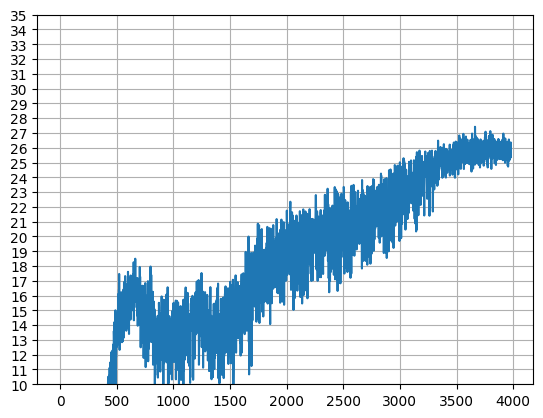

In [10]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
plt.plot(-10*np.log10(losses)+6.02)
plt.yticks(range(10,36));
plt.ylim([10,35])
plt.grid()

77.864 KB
10.100071920271242x compression ratio
7.111111111111111x dimension reduction
19.74511625289917 dB PSNR


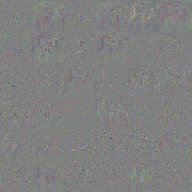

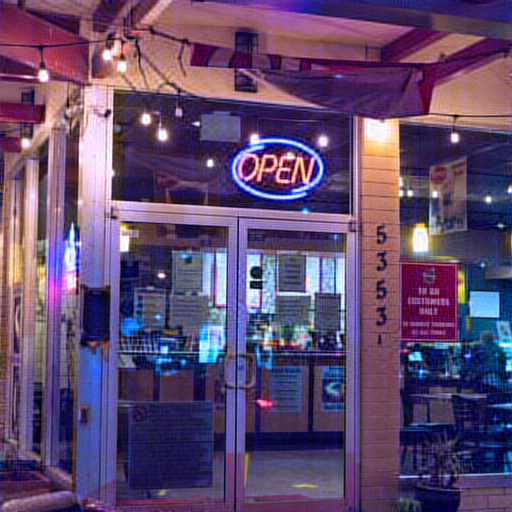

In [31]:
from walloc.walloc import latent_to_pil, pil_to_latent
model.eval()
config.img_size=512
img = CenterCrop(config.img_size)(dataset['validation'][28]['image'])
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()
with torch.no_grad():
    latent = model.encode(x)
webp = latent_to_pil(latent.cpu(),n_bits=config.latent_bits, C=3)
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer()) + sum(4*nb[1].numel() for nb in model.compandGN.named_buffers())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")
latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=config.latent_bits, C=3).to(device)
with torch.no_grad():
    x_hat = model.decode(latent_decoded)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")

display(webp[0])
ToPILImage()(x_hat[0]/2+0.5)

(107.0, 147.0)

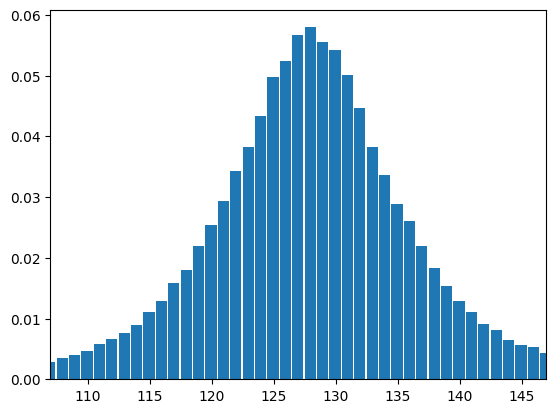

In [35]:
plt.hist(np.array(webp[0]).flatten(),bins=256,range=(-0.5,255.5),width=0.9,density=True);
plt.xlim([127-20,127+20])

5.868746048837625


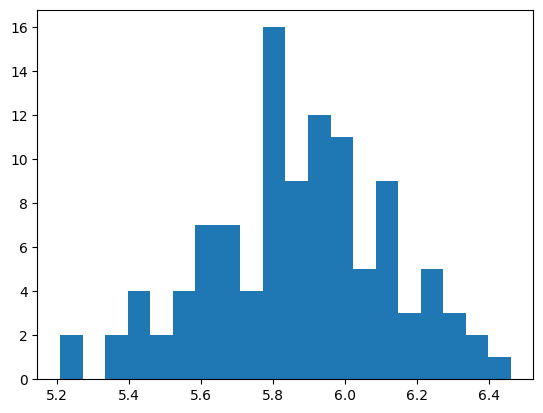

In [37]:
channel_bits = [np.log2(latent[0,i].unique().numel()) for i in range(config.latent_dim)]
plt.hist(channel_bits,bins=20);
print(np.mean(channel_bits))

In [38]:
img.crop((0,0,config.img_size,config.img_size)).save("test.jpg",quality=50)
jpeg = PIL.Image.open("test.jpg")
MSE = torch.nn.functional.mse_loss(PILToTensor()(jpeg).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
!du -sh test.jpg
# display(jpeg)

28.53667449951172 PSNR
40K	test.jpg
